In [1]:
%matplotlib inline

from __future__ import absolute_import
from __future__ import print_function

import tensorflow as tf
import numpy as np

import os
import codecs
import nltk.data
import collections
from glob import glob
from random import shuffle
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords as nltk_stopwords
import matplotlib.pyplot as plt

punctuation_remover = RegexpTokenizer(r'\w+')
stopwords = nltk_stopwords.words('english')
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [2]:
sess = tf.InteractiveSession()

In [3]:
vocab_size = 50000

def stopword_filter(text):
    return " ".join([word for word in text.split() if word not in stopwords])

def read_name_data(data_dir):
    with open(os.path.join(data_dir, 'name.txt')) as f:
        name_lists = f.readlines()
        
    names = [name.lower().strip().split('\t') for name in name_lists]

    #name_counter = collections.Counter([word for name_set in names for name in name_set for word in name.split()])
    #print(name_counter.most_common(100))

    name2idx = {}
    nameword2idx = {}

    for idx, name_set in enumerate(names):
        for name in name_set:
            word_in_name = name.split()
            name_without_punctuation = " ".join(punctuation_remover.tokenize(name))
            name2idx[name_without_punctuation] = idx

            for name in [name_without_punctuation] + word_in_name:
                nameword2idx[name] = idx

    idx2name = dict(zip(name2idx.values(), name2idx.keys()))
    
    return names, name2idx, idx2name, nameword2idx

def read_data_as_words(data_dir):
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    
    text = ""
    for filename in glob(os.path.join(data_dir, "*.txt")):
        if 'name.txt' in filename:
            continue
        with open(filename) as f:
            text += f.read()
    return text.split()

def read_data_as_sentences(data_dir, nameword2idx):
    sentences = []

    for filename in glob(os.path.join(data_dir, "*.txt")):
        if 'name.txt' in filename:
            continue

        with codecs.open(filename, 'r', 'utf-8') as f:
            nltk_splited_sentences = tokenizer.tokenize(stopword_filter(f.read().encode('ascii','ignore').lower()))
            current_sentences = [" ".join(punctuation_remover.tokenize(sentence)) for sentence in nltk_splited_sentences
                                 if any(word in nameword2idx.keys() for word in sentence.split())]
            sentences.extend(current_sentences)

            print(" [*] %s finished: %d / %d" % (filename, len(current_sentences), len(nltk_splited_sentences)))

    idx2sentences = {}
    for sentence in sentences:
        inserted_ids = []
        for idx in [idx for nameword, idx in nameword2idx.items() if nameword in sentence]:
            if idx not in inserted_ids:
                idx2sentences.setdefault(idx, []).append(" ".join([word for word in sentence.split() if word not in nameword2idx.keys()]))
                inserted_ids.append(idx)

    new_sentences = []
    name_idx_of_sentence = []
    for idx in idx2sentences.keys():
        for sentence in idx2sentences[idx]:
            new_sentences.append(sentence)
            name_idx_of_sentence.append(idx)

    print(" [*] Total sentences : %d" % (len(sentences)))
    return new_sentences, name_idx_of_sentence

In [22]:
def build_dataset_from_sentences(sentences, name_idx_of_sentence):
    words = [word for sentence in sentences for word in sentence.split()]
    
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocab_size - 1))

    word2idx = dict()
    for word, _ in count:
        word2idx[word] = len(word2idx)

    data = list()
    label_data = list()
    unk_count = 0
    for sentence, name_idx in zip(sentences, name_idx_of_sentence):
        for word in sentence.split():
            if word in word2idx:
                index = word2idx[word]
            else:
                index = 0
                unk_count = unk_count + 1
            data.append(index)
            label_data.append(name_idx)

    count[0][1] = unk_count
    idx2word = dict(zip(word2idx.values(), word2idx.keys()))

    return word2idx, idx2word, data, label_data, count

def generate_batch(data, label_data, batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)

    for i in xrange(batch_size):
        batch[i] = data[data_index]
        labels[i] = label_data[data_index]
        
        data_index = (data_index + 1) % len(data)

    return batch, labels

In [23]:
data_dir = './data'

words = read_data_as_words(data_dir)
print('Data size :', len(words))

names, name2idx, idx2name, nameword2idx = read_name_data(data_dir)
print('# of names :', len(names))

sentences, name_idx_of_sentence = read_data_as_sentences(data_dir, nameword2idx)

print("Unkown names : %s" % (set(name2idx.values()) - set(name_idx_of_sentence)))

Data size : 1081571
# of names : 189
 [*] ./data/1.txt finished: 2263 / 6358
 [*] ./data/6.txt finished: 4416 / 11431
 [*] ./data/2.txt finished: 2704 / 6496
 [*] ./data/5.txt finished: 6956 / 17300
 [*] ./data/7.txt finished: 4917 / 14304
 [*] ./data/4.txt finished: 5466 / 13804
 [*] ./data/3.txt finished: 3483 / 8660
 [*] Total sentences : 30205
Unkown names : set([101, 78, 113, 179, 183, 25])


In [24]:
word2idx, idx2word, data, label_data, count = build_dataset_from_sentences(sentences, name_idx_of_sentence)

combined = zip(data, label_data)
shuffle(combined)

data[:], label_data[:] = zip(*combined)

print('Most common words (+UNK) :', count[:5])

Most common words (+UNK) : [['UNK', 0], ('said', 15552), ('back', 5316), ('could', 4987), ('him', 4901)]


In [25]:
data_index = 0
batch_size = 128
skip_window = 4
num_skips = 2

name_size = len(idx2name)
embed_size = 128
neg_sample_size = 64

num_steps = 100001

x_ = tf.placeholder(tf.int32, [batch_size, 1])
x = tf.reshape(x_, [batch_size])
y_ = tf.placeholder(tf.int32, [batch_size])
y = tf.reshape(y_, [batch_size, 1])
neg_y = tf.placeholder(tf.int32, [neg_sample_size])

init_width = 0.5 / embed_size

embed = tf.Variable(tf.random_uniform([name_size, embed_size], -init_width, init_width))
w = tf.Variable(tf.zeros([vocab_size, embed_size]))
b = tf.Variable(tf.zeros([vocab_size]))

pos_embed = tf.nn.embedding_lookup(embed, x, name="pos_embed") # [batch_size x embed_size]
# pos_w = tf.nn.embedding_lookup(w, y, name="pos_w")             # [batch_size x embed_size]
# pos_b = tf.nn.embedding_lookup(b, y, name="pos_b")             # [batch_size x 1]

# pos_y_ = tf.add(tf.reduce_sum(tf.mul(pos_embed, pos_w), 1), pos_b) # [batch_size]

# # neg_embed = pos_embed
# neg_w = tf.nn.embedding_lookup(w, neg_y, name="neg_w") # [neg_sample_size x embed_size]
# neg_b = tf.nn.embedding_lookup(b, neg_y, name="neg_b") # [neg_sample_size]

# neg_y_ = tf.matmul(pos_embed, neg_w, transpose_b=True) + neg_b # [batch_size x neg_sample_size]

# pos_y = tf.ones_like(pos_y_)
# neg_y = tf.ones_like(neg_y_)

# pos_loss = tf.nn.sigmoid_cross_entropy_with_logits(pos_y_, tf.ones_like(pos_y_))
# neg_loss = tf.nn.sigmoid_cross_entropy_with_logits(neg_y_, tf.zeros_like(neg_y_))

loss = tf.reduce_mean(
      tf.nn.nce_loss(w, b, pos_embed, y, neg_sample_size, name_size)
)

##################
# Optimizer
##################

global_step = tf.Variable(0, name="global_step")
inc = global_step.assign_add(1)

# total_word_processed = float(word_per_epoch * epochs_to_train)

learning_rate = 0.01
lr = learning_rate * tf.maximum(
    0.001,
    1.0 - tf.cast(global_step, tf.float32) / num_steps
)

# loss = (tf.reduce_sum(pos_loss) + tf.reduce_sum(neg_loss))/batch_size

with tf.control_dependencies([inc]):
    #train = tf.train.GradientDescentOptimizer(lr).minimize(loss, global_step=global_step)
    train = tf.train.GradientDescentOptimizer(0.01).minimize(loss, global_step=global_step)
    
# norm = tf.sqrt(tf.reduce_sum(tf.square(embed), 1, keep_dims=True))
# nembed = embed / norm
nembed = tf.nn.l2_normalize(embed, 1)

In [26]:
tf.initialize_all_variables().run()
average_loss = 0
for step in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch(
        data, label_data, batch_size, num_skips, skip_window
    )
    feed_dict = {x_: batch_labels, y_: batch_inputs}
    _, loss_val = sess.run([train, loss], feed_dict=feed_dict)
    average_loss += loss_val

    if step % 2000 == 0:
        if step > 0:
            average_loss = average_loss / 2000

        print("Average loss at step ", step, ": ", average_loss)
        average_loss = 0

Average loss at step  0 :  83.2212524414
Average loss at step  2000 :  30.0889688327
Average loss at step  4000 :  5.06691720152
Average loss at step  6000 :  3.39342215681
Average loss at step  8000 :  2.88202662349
Average loss at step  10000 :  2.65739094311
Average loss at step  12000 :  2.51088905919
Average loss at step  14000 :  2.41784141642
Average loss at step  16000 :  2.36691632742
Average loss at step  18000 :  2.32056955266
Average loss at step  20000 :  2.28767826372
Average loss at step  22000 :  2.26265701407
Average loss at step  24000 :  2.24975500959
Average loss at step  26000 :  2.22163163692
Average loss at step  28000 :  2.21683291548
Average loss at step  30000 :  2.20968247664
Average loss at step  32000 :  2.19114108115
Average loss at step  34000 :  2.18620909679
Average loss at step  36000 :  2.18669234931
Average loss at step  38000 :  2.17552820688
Average loss at step  40000 :  2.16525470996
Average loss at step  42000 :  2.17194916141
Average loss at st

In [27]:
for idx, count in collections.Counter(label_data).items():
    print(idx, idx2name[idx], ":", count)

0 hogwarts : 8132
1 aberforth dumbledore : 456
2 mad eye : 4642
3 brian : 1005
4 al : 112711
5 alecto carrow : 111
6 alice longbottom : 106
7 alicia spinnet : 734
8 amelia bones : 130
9 amos diggory : 192
10 amycus carrow : 278
11 andromeda tonks : 55
12 angelina johnson : 1169
13 anthony goldstein : 152
14 antioch peverell : 7
15 antonin dolohov : 288
16 arabella figg : 588
17 aragog : 505
18 argus filch : 2412
19 ariana dumbledore : 24313
20 arthur weasley : 384
21 augusta longbottom : 46
22 augustus rookwood : 200
23 aurora sinistra : 84
24 bane : 223
26 barty : 2884
27 bathilda bagshot : 723
28 bathsheba babbling : 30
29 beedle the bard : 178
30 bellatrix lestrange : 1712
31 bertha jorkins : 383
32 blaise zabini : 412
33 buckbeak : 907
34 cadmus peverell : 7
35 cedric diggory : 2951
36 charity burbage : 89
37 charlie weasley : 809
38 cho chang : 13973
39 colin creevey : 595
40 cormac mclaggen : 599
41 cornelius fudge : 3517
42 crookshanks : 1495
43 cuthbert binns : 530
44 dean thom

In [18]:
saver = tf.train.Saver()
saver.save(sess, os.path.join("./", "p2v.ckpt"), global_step=global_step)

'./p2v.ckpt-200002'

In [19]:
nearby_word = tf.placeholder(dtype=tf.int32)  # word id
nearby_emb = tf.reshape(tf.gather(nembed, nearby_word), [1, embed_size])
nearby_dist = tf.matmul(nearby_emb, nembed, transpose_b=True)
nearby_val, nearby_idx = tf.nn.top_k(nearby_dist, min(100, vocab_size))

def nearby(words, num=20):
    ids = np.array([name2idx.get(x, 0) for x in words])
    vals, idx = sess.run(
        [nearby_val, nearby_idx], {nearby_word: ids})
    for i in xrange(len(words)):
        print("\n%s\n=====================================" % (words[i]))
        for (neighbor, distance) in zip(idx[i, :num], vals[i, :num]):
            print("%-20s %6.4f" % (idx2name[neighbor], distance))

In [31]:
nearby(['harry potter'])


harry potter
harry potter         1.0000
gregory goyle sr     0.1484
lucius malfoy        0.1477
cornelius fudge      0.1453
alecto carrow        0.1448
william weasley      0.1370
petunia dursley      0.1225
dolores umbridge     0.1209
rubeus hagrid        0.1208
hepzibah smith       0.0991
vernon dursley       0.0983
dora                 0.0974
helga hufflepuff     0.0956
lily luna potter     0.0947
luna lovegood        0.0929
hogwarts             0.0908
orion                0.0906
bellatrix lestrange  0.0905
aurora sinistra      0.0866
amelia bones         0.0838


In [30]:
nearby(['severus snape'])


severus snape
severus snape        1.0000
fenrir greyback      0.1751
helga hufflepuff     0.1585
fred weasley         0.1450
argus filch          0.1425
rubeus hagrid        0.1413
rolanda hooch        0.1290
kreacher             0.1259
dobby                0.1253
vincent crabbe jr    0.1225
buckbeak             0.1175
walden macnair       0.1167
igor karkaroff       0.1122
newt scamander       0.1115
andromeda tonks      0.1007
barty                0.0951
regulus arcturus black 0.0949
frank longbottom     0.0934
tom riddle           0.0864
cornelius fudge      0.0833


In [29]:
nearby(['albus dumbledore'])


albus dumbledore
brian                1.0000
phineas nigellus black 0.1734
mrs norris           0.1719
augustus rookwood    0.1634
mad eye              0.1512
gregory goyle sr     0.1315
hannah abbott        0.1297
james sirius potter  0.1294
buckbeak             0.1291
cuthbert binns       0.1241
ariana dumbledore    0.1192
ginevra weasley      0.1167
elphias doge         0.1148
jean                 0.1038
bellatrix lestrange  0.1008
nagini               0.1000
gilderoy lockhart    0.0987
katie bell           0.0969
alicia spinnet       0.0955
irma pince           0.0927


In [20]:
nearby(['albus dumbledore'])


albus dumbledore
brian                1.0000
orion                0.9999
cornelius fudge      0.9999
cho chang            0.9999
narcissa malfoy      0.9999
hogwarts             0.9999
al                   0.9999
george weasley       0.9999
the                  0.9999
stan shunpike        0.9998
jean                 0.9998
ted tonks            0.9998
tom                  0.9998
severus snape        0.9998
ariana dumbledore    0.9998
neville longbottom   0.9998
lee jordan           0.9998
ginevra weasley      0.9998
ronald weasley       0.9998
teddy lupin          0.9998


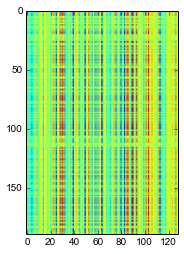

In [28]:
plt.imshow((embed.eval()*100).astype(np.int32))

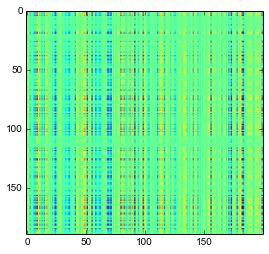

In [21]:
plt.imshow((embed.eval()*100).astype(np.int32))

In [ ]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))    #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.savefig(filename)
try:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
    labels = [reverse_dictionary[i] for i in xrange(plot_only)]
    plot_with_labels(low_dim_embs, labels)
except ImportError:
    print("Please install sklearn and matplotlib to visualize embeddings.")

In [ ]:
flags = tf.app.flags

flags.DEFINE_string("data_dir", './data/', "Directory which contains data files")

FLAGS = flags.FLAGS

class Options(object):
    def __init__(self):
        self.data_dir = FLAGS.data_dir

def main():
    if not FLAGS.data_dir:
        print("--data_dir must be specified")
        sys.exit(1)

    opts = Options()
    read_data(opts.data_dir)
